### Demo - Simulations

In this notebook, we demonstrate how to infer fitness landscapes with FiTree using simulated tumor mutation trees.

In [1]:
import numpy as np
import pymc as pm
import jax
import pandas as pd
import fitree
import arviz as az

### 1. Tree Generation

We focus on a simple example with 5 mutations and 500 trees. We use the following ground-truth parameters:

- The number of wild-type cells is $C_0 = 10^5$;

- The scaling factor is $C_{sampling} = 10^8$;

- The number of sequenced cells is $C_{seq} = 10^4$;

- Common death rate is $\beta = 1$;

- Maximum observation time $t_{\max} = 100$;

- All mutation rates are set to be $3 \times 10^{-7}$. 

In [19]:
n_mutations = 5
N_trees = 500
C_0 = 1e5
C_sampling = 1e8
C_seq = 1e4
t_max = 100
common_beta = 1.0
mu_vec = np.ones(n_mutations) * 3e-7
mutation_labels = [f"m{i}" for i in range(n_mutations)]

We set the following fitness matrix:

In [20]:
F_mat = np.ones((n_mutations, n_mutations))
F_mat[0, 0] = 1.2
F_mat[1, 1] = 0.8
F_mat[2, 2] = 1.1
F_mat[0, 1] = 1.5
F_mat[0, 2] = 0.7
F_mat = np.log(F_mat)

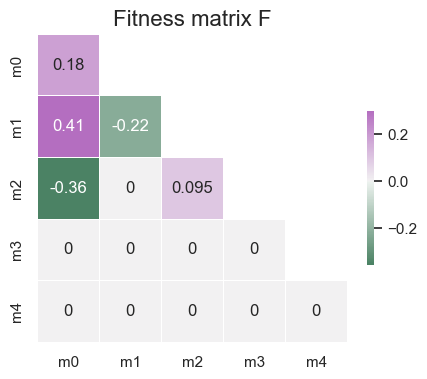

In [21]:
fitree.plot_fmat(F_mat, mutation_labels, figsize=(5, 4), to_sort=False)

Now, we can simulate trees using the tau-leaping algorithm. The pseudocode is provided in Algorithm 1 in the supplement of the [paper](https://www.biorxiv.org/content/10.1101/2025.01.24.634649v1).

In [5]:
# Warning: this code will take a while to run
# Alternatively, you can load the results from the saved file
cohort = fitree.generate_trees(
    rng=np.random.default_rng(123),
    n_mutations=n_mutations,
    N_trees=N_trees,
    mu_vec=mu_vec,
    F_mat=F_mat,
    common_beta=common_beta,
    C_0=C_0,
    C_seq=C_seq,
    C_sampling=C_sampling,
    t_max=t_max,
    tau=1e-2,
    return_time=True,
    parallel=True,
)

In [6]:
fitree.save_cohort_to_json(cohort, "simulated_cohort.json")

In [7]:
cohort = fitree.load_cohort_from_json("simulated_cohort.json")

One can view the the simulated trees using the *plot_tree* function.

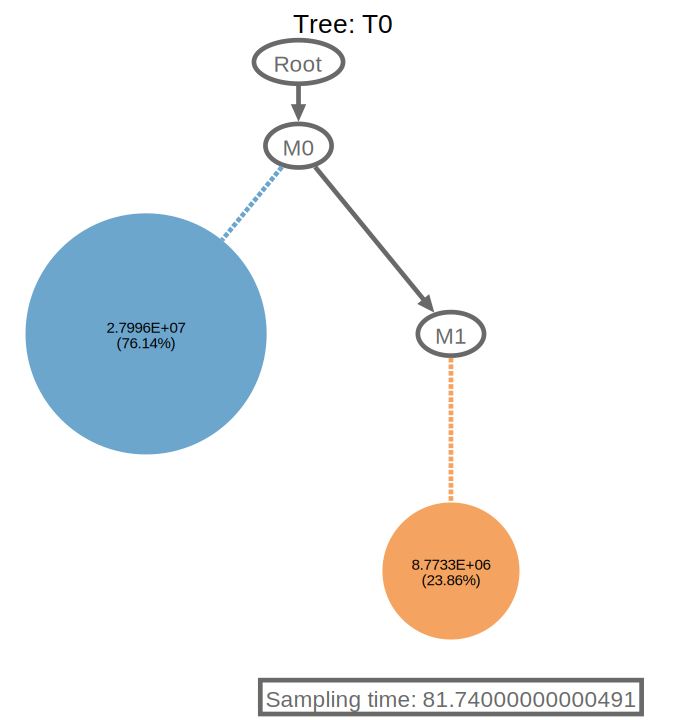

In [22]:
fitree.plot_tree(cohort, 0)

### 2. Inference of fitness matrix

We will look at three cases that were presented in the paper:
| Case | Masks on Rare Mutations | Prior on Lifetime Risk |
|------|-------------------------|------------------------|
| 1    | ✓                       | ✓                      |
| 2    | ✗                       | ✓                      |
| 3    | ✗                       | ✗                      |


#### Case 1:

In [23]:
vec_trees, _ = fitree.wrap_trees(cohort, augment_max_level=2)

In [34]:
vec_trees = fitree.update_params(vec_trees, F_mat)
true_lifetime_risk = float(fitree.compute_normalizing_constant(vec_trees))

In [25]:
fitree_joint_likelihood = fitree.FiTreeJointLikelihood(
    cohort,
    augment_max_level=2,
    conditioning=False,
    lifetime_risk_mean=true_lifetime_risk,
    lifetime_risk_std=0.001,
)

model = fitree.prior_fitree(
    cohort,
    diag_sigma=0.1,
    offdiag_sigma=0.1,
    min_occurrences=5,   # masking the rare mutations (<5 occurrences)
)

In [30]:
with model:
    pm.Potential(
        "joint_likelihood",
        fitree_joint_likelihood(
            model.fitness_matrix,  # pyright: ignore
        ),  # pyright: ignore
    )
    trace1 = pm.sample(
        draws=500,
        tune=500,
        chains=1,
        return_inferencedata=True,
    )

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [diag_entries]
>Metropolis: [offdiag_entries]


Output()

/Users/luox/anaconda3/envs/FiTree/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:318: RuntimeWarning:
overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),

Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 375 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [31]:
F_mat_posterior = trace1.posterior["fitness_matrix"].values
inferred_F_mat = np.median(F_mat_posterior, axis=(0, 1))

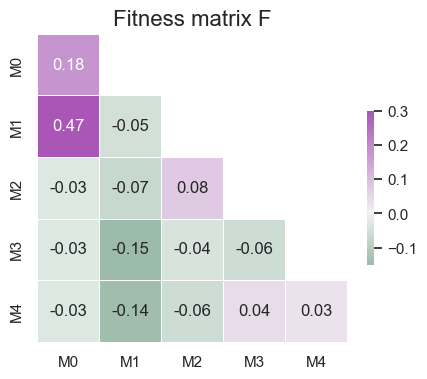

In [32]:
fitree.plot_fmat(np.round(inferred_F_mat, 2), figsize=(5, 4), to_sort=False)

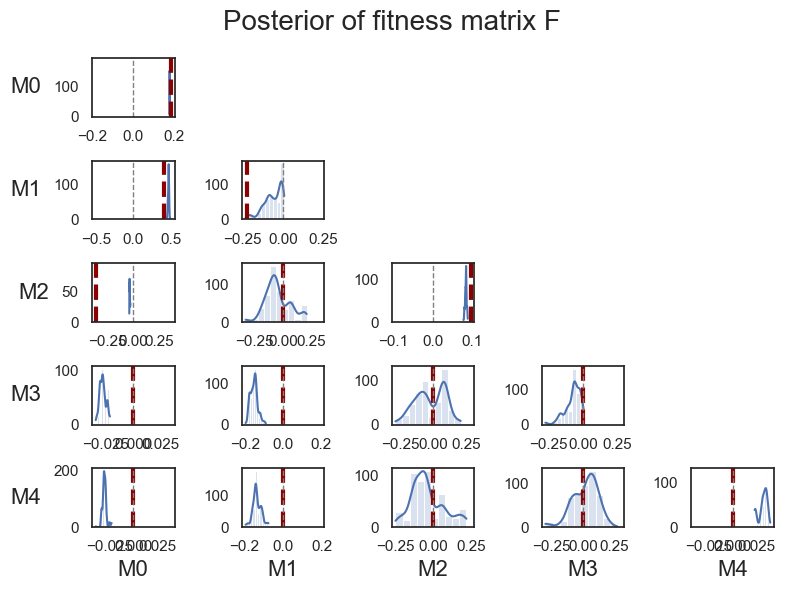

In [33]:
fitree.plot_fmat_posterior(F_mat_posterior.reshape(-1, cohort.n_mutations, cohort.n_mutations), F_mat, figsize=(8, 6));

#### Case 2:

In [35]:
fitree_joint_likelihood = fitree.FiTreeJointLikelihood(
    cohort,
    augment_max_level=2,
    conditioning=False,
    lifetime_risk_mean=true_lifetime_risk,
    lifetime_risk_std=0.001,
)

model = fitree.prior_fitree(
    cohort,
    diag_sigma=0.1,
    offdiag_sigma=0.1,
    min_occurrences=0, # no masking
)

In [36]:
with model:
    pm.Potential(
        "joint_likelihood",
        fitree_joint_likelihood(
            model.fitness_matrix,  # pyright: ignore
        ),  # pyright: ignore
    )
    trace2 = pm.sample(
        draws=500,
        tune=500,
        chains=1,
        return_inferencedata=True,
    )

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [diag_entries]
>Metropolis: [offdiag_entries]


Output()

/Users/luox/anaconda3/envs/FiTree/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:318: RuntimeWarning:
overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),

Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 365 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [37]:
F_mat_posterior = trace2.posterior["fitness_matrix"].values
inferred_F_mat = np.median(F_mat_posterior, axis=(0, 1))

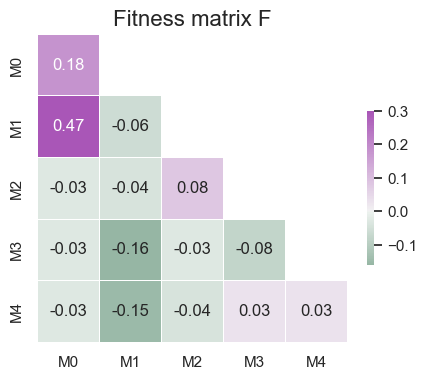

In [38]:
fitree.plot_fmat(np.round(inferred_F_mat, 2), figsize=(5, 4), to_sort=False)

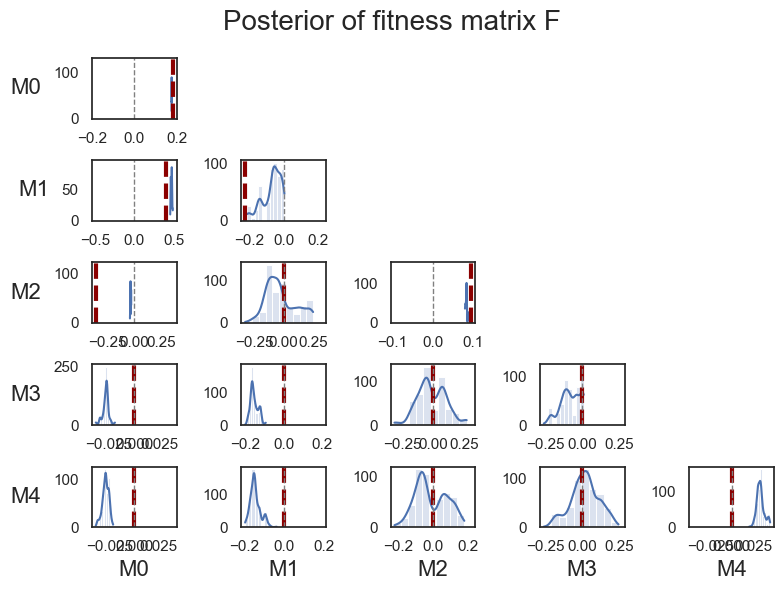

In [39]:
fitree.plot_fmat_posterior(F_mat_posterior.reshape(-1, cohort.n_mutations, cohort.n_mutations), F_mat, figsize=(8, 6));

#### Case 3:

In [9]:
fitree_joint_likelihood = fitree.FiTreeJointLikelihood(
    cohort,
    augment_max_level=2,
    conditioning=True
)

model = fitree.prior_fitree(
    cohort,
    diag_sigma=0.1,
    offdiag_sigma=0.1,
    min_occurrences=0,
)

In [11]:
with model:
    pm.Potential(
        "joint_likelihood",
        fitree_joint_likelihood(
            model.fitness_matrix,  # pyright: ignore
        ),  # pyright: ignore
    )
    trace3 = pm.sample(
        draws=500,
        tune=500,
        chains=1,
        return_inferencedata=True,
    )

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [diag_entries]
>Metropolis: [offdiag_entries]


Output()

/Users/luox/anaconda3/envs/FiTree/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:318: RuntimeWarning:
overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),

Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 443 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [27]:
F_mat_posterior = trace3.posterior["fitness_matrix"].values
inferred_F_mat = np.median(F_mat_posterior, axis=(0, 1))

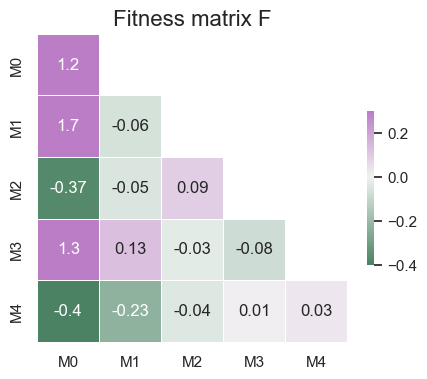

In [28]:
fitree.plot_fmat(np.round(inferred_F_mat, 2), figsize=(5, 4), to_sort=False)

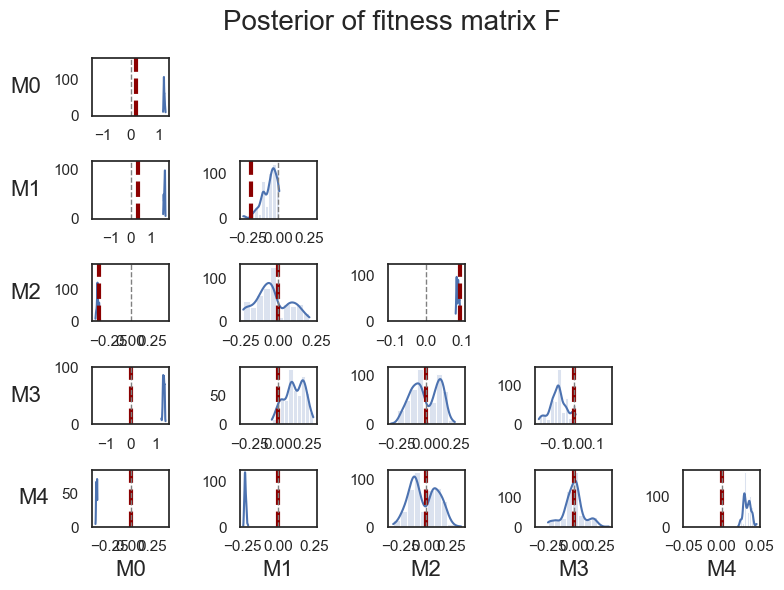

In [29]:
fitree.plot_fmat_posterior(F_mat_posterior.reshape(-1, cohort.n_mutations, cohort.n_mutations), F_mat, figsize=(8, 6));